In [ ]:
import os, json, re, string
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd

results_dir = "results"
files = {
    "Qwen2.5-7B": "predictions_techqa_llama.jsonl",
    "LLaMA-3.1-8B": "predictions_techqa_qwen.jsonl"
}
csv_out = "squadv2_metrics_em_f1.csv"

def normalize_answer(s: str) -> str:
    if s is None:
        return ""
    s = s.lower()
    exclude = set(string.punctuation)
    s = "".join(ch for ch in s if ch not in exclude)
    s = re.sub(r"\b(a|an|the)\b", " ", s)
    s = " ".join(s.split())
    return s

def f1_score(prediction: str, ground_truth: str) -> float:
    pred = normalize_answer(prediction).split()
    gold = normalize_answer(ground_truth).split()
    if len(gold) == 0 and len(pred) == 0:
        return 1.0
    if len(gold) == 0 or len(pred) == 0:
        return 0.0
    common = defaultdict(int)
    for t in gold:
        common[t] += 1
    num_same = 0
    for t in pred:
        if common[t] > 0:
            num_same += 1
            common[t] -= 1
    if num_same == 0:
        return 0.0
    precision = num_same / len(pred)
    recall = num_same / len(gold)
    return 2 * precision * recall / (precision + recall)

def exact_match_score(prediction: str, ground_truth: str) -> int:
    return int(normalize_answer(prediction) == normalize_answer(ground_truth))

def read_jsonl(path):
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            if line.strip():
                yield json.loads(line)

def evaluate_file(jsonl_path: str):
    total = 0
    em_sum = 0
    f1_sum = 0.0
    for ex in read_jsonl(jsonl_path):
        pred = ex.get("predicted_answer", "")
        gold = ex.get("gold_answer", "")
        em_sum += exact_match_score(pred, gold)
        f1_sum += f1_score(pred, gold)
        total += 1
    if total == 0:
        return {"exact": 0.0, "f1": 0.0, "total": 0}
    return {
        "exact": 100.0 * em_sum / total,
        "f1": 100.0 * (f1_sum / total),
        "total": total
    }

rows = []
for model, fname in files.items():
    path = os.path.join(results_dir, fname)
    if os.path.exists(path):
        res = evaluate_file(path)
        rows.append({"model": model, "EM": res["exact"], "F1": res["f1"], "total": res["total"]})
    else:
        rows.append({"model": model, "EM": None, "F1": None, "total": 0})

df = pd.DataFrame(rows)

plot_df = df.dropna(subset=["EM", "F1"]).copy()

# Sort by F1 desc for nicer comparison
if len(plot_df) > 0:
    plot_df = plot_df.sort_values(by="F1", ascending=False)

df.to_csv(csv_out, index=False)

plt.figure(figsize=(10, 6))

if len(plot_df) > 0:
    models = plot_df["model"].tolist()
    x = range(len(models))
    bar_width = 0.35

    em_scores = plot_df["EM"].tolist()
    f1_scores = plot_df["F1"].tolist()

    em_bars = plt.bar([i - bar_width/2 for i in x], em_scores, width=bar_width, label="EM")
    f1_bars = plt.bar([i + bar_width/2 for i in x], f1_scores, width=bar_width, label="F1")

    plt.xticks(list(x), models, rotation=15)
    plt.ylabel("Score (%)")
    plt.ylim(0, 100)
    plt.title("SQuAD v2.0 Manual Evaluation: EM vs F1")

    # Add value labels on bars
    def autolabel(bars):
        for b in bars:
            h = b.get_height()
            plt.text(b.get_x() + b.get_width()/2, h + 1, f"{h:.1f}", ha='center', va='bottom', fontsize=9)
    autolabel(em_bars)
    autolabel(f1_bars)

    plt.grid(axis="y", linestyle="--", alpha=0.4)

    plt.legend()
else:
    plt.text(0.5, 0.5, "No evaluable models found.\n(Check file paths.)", ha="center", va="center")
    plt.axis("off")

plt.tight_layout()
plt.show()

---

## Annotators

In [2]:
df

,item_id,annotator,valid,reason
0,1,thomas,0,Annotation Error
1,1,kent,1,Correct
2,1,cyril,1,Correct
3,1,chatgpt,0,Unsupported Context
4,2,thomas,0,Hallucination
...,...,...,...,...
475,119,chatgpt,1,Correct
476,120,thomas,0,Ambiguous
477,120,kent,1,Correct
478,120,cyril,1,Correct


<Figure size 640x480 with 0 Axes>

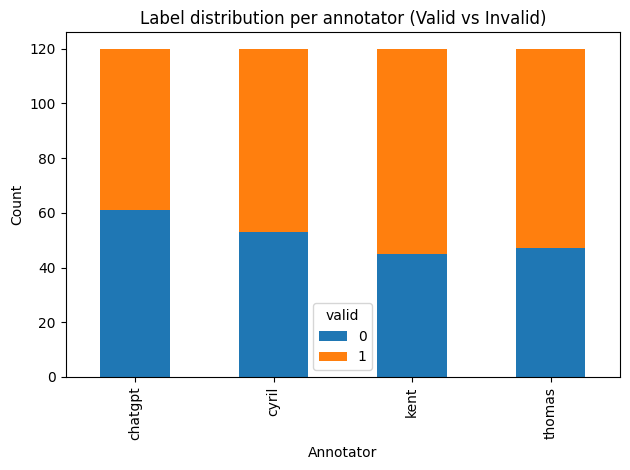

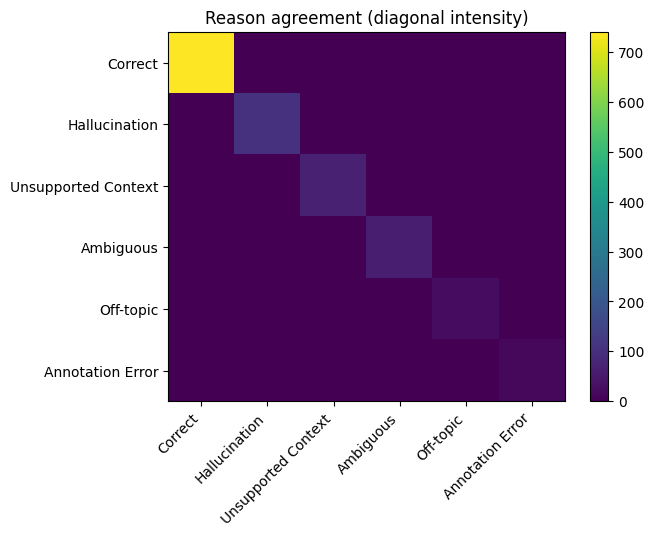

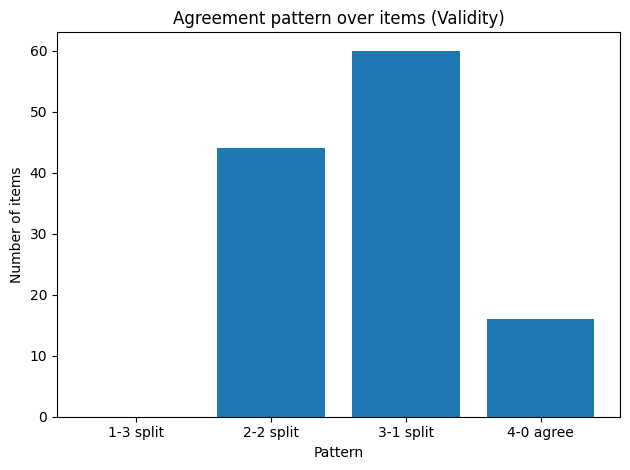

In [1]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt

rng = np.random.default_rng(42)

# -----------------------------
# 1) Dummy annotations
# -----------------------------
N_ITEMS = 120
annotators = ["thomas", "kent", "cyril", "chatgpt"]
reasons = ["Correct", "Hallucination", "Unsupported Context", "Ambiguous", "Off-topic", "Annotation Error"]

rows = []
for item_id in range(1, N_ITEMS + 1):
    difficulty = rng.beta(2, 5)
    true_invalid_prob = 0.35 + 0.3 * difficulty
    biases = {"thomas": 0.0, "kent": -0.02, "cyril": -0.05, "chatgpt": 0.08}
    for ann in annotators:
        p_invalid = np.clip(true_invalid_prob + biases[ann], 0.05, 0.95)
        valid = int(rng.uniform() > p_invalid)
        if valid == 1:
            reason = "Correct"
        else:
            invalid_reason_probs = np.array([
                0.30 + 0.2 * difficulty,
                0.25 + 0.1 * difficulty,
                0.20 + 0.1 * (1 - difficulty),
                0.15,
                0.10
            ])
            invalid_reason_probs /= invalid_reason_probs.sum()
            reason = rng.choice(reasons[1:], p=invalid_reason_probs)
        rows.append({"item_id": item_id, "annotator": ann, "valid": valid, "reason": reason})

df = pd.DataFrame(rows)

# -----------------------------
# 3) Plots
# -----------------------------
# (a) Label distribution
plt.figure()
df.groupby(["annotator", "valid"]).size().unstack(fill_value=0).plot(kind="bar", stacked=True)
plt.title("Label distribution per annotator (Valid vs Invalid)")
plt.xlabel("Annotator"); plt.ylabel("Count")
plt.tight_layout() 

# (b) Reason heatmap
co = pd.DataFrame(0, index=reasons, columns=reasons, dtype=int)
for _, g in df.groupby("item_id"):
    rs = g["reason"].tolist()
    for r1, r2 in itertools.product(rs, rs):
        if r1 == r2:
            co.loc[r1, r2] += 1
plt.figure()
plt.imshow(co.values, aspect="auto"); plt.xticks(range(len(reasons)), reasons, rotation=45, ha="right")
plt.yticks(range(len(reasons)), reasons); plt.title("Reason agreement (diagonal intensity)")
plt.colorbar() 

# (c) Agreement histogram
fig3 = plt.figure()
agree_counts = []
for item_id, g in df.groupby("item_id"):
    counts = g["valid"].value_counts().to_dict()
    agree_counts.append(max(counts.get(0,0), counts.get(1,0)))
agree_counts = pd.Series(agree_counts)
plt.hist(agree_counts, bins=[1,2,3,4,5], align='left', rwidth=0.8)
plt.xticks([1,2,3,4], ["1-3 split","2-2 split","3-1 split","4-0 agree"])
plt.title("Agreement pattern over items (Validity)")
plt.xlabel("Pattern")
plt.ylabel("Number of items")
plt.tight_layout() 